In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

from pathlib import Path

cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

In [2]:
def binned_wage(group, wage_var='RWKWAGE', percentile=0.5, 
                bins=list(np.arange(-1, 6000, 50.0)), 
                bin_size=50.0, weight='PWORWGT'):
    '''
    Return BLS-styled binned decile/percentile wage
    '''
    bin_cut = lambda x: pd.cut(x[wage_var], bins, include_lowest=True)
    cum_sum = lambda x: x[weight].cumsum()
    df = (group.sort_values(wage_var)
               .assign(WAGE_BIN = bin_cut, CS = cum_sum))
    pct_wgt = df[weight].sum() * percentile
    pct_bin = df.iloc[df['CS'].searchsorted(pct_wgt)].WAGE_BIN
    wgt_btm, wgt_top = (df.loc[df['WAGE_BIN'] == pct_bin, 'CS']
                          .iloc[[0, -1]].values)
    if pct_bin.left <= 0:
        pct_value = 0
    else:
        pct_value = ((((pct_wgt - wgt_btm) / 
                       (wgt_top - wgt_btm)) * bin_size) + pct_bin.left)
    return pct_value

def cps_6mo(cps_dir, cps_dt, cols):
    '''
    Return 6 months of bd_CPS variables cols ending cps_dt
    '''

    if 'MONTH' not in cols:
        cols = cols + ['MONTH']
    if 'YEAR' not in cols:
        cols = cols + ['YEAR']

    cps_year = cps_dt.year
    cps_month = cps_dt.month
    cps_month6 = (cps_dt - pd.DateOffset(months=5)).month
    if cps_month < 6:
        cps_year1 = cps_year - 1
        cps_year2 = cps_year
        df = (pd.read_feather(cps_dir / f'cps{cps_year1}.ft', columns=cols)
              .query('MONTH >= @cps_month6')
              .append(pd.read_feather(cps_dir / f'cps{cps_year2}.ft', columns=cols)
                        .query('MONTH <= @cps_month')))
    else:
        df = (pd.read_feather(cps_dir / f'cps{cps_year}.ft', columns=cols)
              .query('MONTH >= @cps_month6 and MONTH <= @cps_month'))
        
    return df

In [4]:
# Collect data
years = [2019, 2020]

cols = ['CPSID', 'MONTH', 'YEAR', 'AGE', 'FEMALE', 'WBHAO', 'EDUC', 
        'PWORWGT', 'PWSSWGT', 'LFS', 'HRSACTT', 'HRSUSL1', 'REGION', 
        'OCCD', 'COW1', 'RHRWAGE', 'RWKWAGE', 'MIS', 'FAMNUM']

self_emp = ["Self-employed Unincorporated", "Self-employed Incorporated"]

formula = 'RHRWAGE ~ AGE + EDUC + WBHAO + C(OCCD) + REGION + FT'

ft = lambda x: np.where(x.HRSUSL1 >= 35, 1, 0)
se = lambda x: np.where(x.COW1.isin(self_emp), 1, 0)

d = {}
medft = {}

for year in years:
    d[year] = (cps_6mo(cps_dir, pd.to_datetime(f'{year}-10-01'), cols)
               .query('MIS in [4, 8]')
               .assign(FT = ft, SE = se))
    
    d[year]['RWKWAGE'] = d[year]['RWKWAGE'].fillna(0)
    
    median_wage = binned_wage(d[year].query('FT == 1 and SE == 0')) * 52
    medft[year] = median_wage
    print(f'Median Real Wage {year}: ${median_wage:,.0f}')

Median Real Wage 2019: $49,811
Median Real Wage 2020: $53,225


In [5]:
# find relationship between wage and personal characteristics

medall = {}

for year in years:
    dfm = d[year]
    reg = {}
    for fem in [0, 1]:
        mod = smf.quantreg(formula, dfm.query('RHRWAGE > 0 and FEMALE == @fem'))
        reg[fem] = mod.fit(q=.5)

        # fill self-employed wage with predicted wage
        query = 'SE == 1 and FEMALE == @fem'
        se_wkwage = reg[fem].predict(dfm.query(query)) * dfm.query(query).HRSACTT
        dfm.loc[se_wkwage.index, 'RWKWAGE'] = se_wkwage
        
    d[year] = dfm
    
    median_wage = binned_wage(d[year]) * 52
    medall[year] = median_wage
    print(f'Median Real Wage {year}: ${median_wage:,.0f}')

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Median Real Wage 2019: $21,807
Median Real Wage 2020: $15,680


In [6]:
# Calculate income at family level
medfam = {}
for year in years:
    dfm = d[year]
    dff = dfm.query('FAMNUM == 1')
    famrwkwage = dff.groupby('CPSID').RWKWAGE.transform('sum')
    famsize = np.sqrt(dff.groupby('CPSID').MONTH.transform('count'))
    famwage = famrwkwage / famsize
    dfm['FAMRWKWAGE'] = 0
    dfm.loc[famwage.index, 'FAMRWKWAGE'] = famwage
    d[year] = dfm
    
    median_wage = binned_wage(d[year], wage_var='FAMRWKWAGE', weight='PWSSWGT') * 52
    medfam[year] = median_wage
    print(f'Median Real Wage {year}: ${median_wage:,.0f}')

Median Real Wage 2019: $23,667
Median Real Wage 2020: $21,967


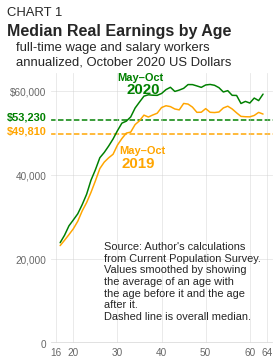

In [7]:
# Chart 1
result = {}
for year in years:
    result[year] = {}
    for age in range(16, 65):
        query = 'FT == 1 and SE == 0 and AGE == @age'
        dfa = d[year].query(query)
        result[year][age] = binned_wage(dfa) * 52
        
(pd.DataFrame(result).rolling(3).mean().shift(-1)
   .dropna().plot(color=['orange', 'green'], figsize=(4, 5), zorder=2, legend=None))
plt.axhline(y=medft[2019], color='orange', linestyle='dashed', zorder=0)
plt.axhline(y=medft[2020], color='green', linestyle='dashed', zorder=0)
plt.axhline(y=0, color='lightgray')
plt.text(5, 78000, 'CHART 1', size=13)
plt.text(5, 73200, 'Median Real Earnings by Age', 
          fontsize=16, weight='bold')
plt.text(7, 69700, 'full-time wage and salary workers', size=13)
plt.text(7, 66300, 'annualized, October 2020 US Dollars', size=13)
plt.yticks([60000, 40000, 20000, 0], ['$60,000', '40,000', '20,000', '0'], size=10, alpha=0.7)
plt.xticks([16, 20, 30, 40, 50, 60, 64], size=10, alpha=0.7)
plt.grid(True, which='major', axis='y', alpha=0.5)
plt.grid(True, which='major', axis='x', alpha=0.5)
plt.ylim(bottom=0)
plt.text(32, 59500, '2020', size=15, color='green', weight='bold')
plt.text(30, 62500, 'May–Oct', size=11, color='green', weight='bold')
plt.text(5, medft[2020], f'${round(medft[2020], -1):,.0f}', size=11, color='green', weight='bold')
plt.text(31, 41800, '2019', size=15, color='orange', weight='bold')
plt.text(30.5, 45200, 'May–Oct', size=11, color='orange', weight='bold')
plt.text(5, medft[2019], f'${round(medft[2019], -1):,.0f}', size=11, color='orange', weight='bold')
text = """
Source: Author's calculations 
from Current Population Survey.
Values smoothed by showing 
the average of an age with 
the age before it and the age 
after it. 
Dashed line is overall median. 
"""
plt.text(27, 3000, text, size=11)
plt.show();

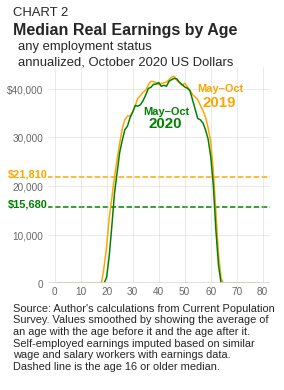

In [8]:
# Chart 2
result = {}
for year in years:
    result[year] = {}
    for age in range(0, 81):
        query = 'AGE == @age'
        dfa = d[year].query(query)
        result[year][age] = binned_wage(dfa, weight='PWSSWGT') * 52
        
(pd.DataFrame(result).rolling(3).mean().shift(-1)
   .dropna().plot(color=['orange', 'green'], figsize=(4, 4), zorder=2, legend=None))
plt.axhline(y=medall[2019], color='orange', linestyle='dashed', zorder=0)
plt.axhline(y=medall[2020], color='green', linestyle='dashed', zorder=0)
plt.axhline(y=0, color='lightgray')
plt.text(-16, 55000, 'CHART 2', size=13)
plt.text(-16, 51200, 'Median Real Earnings by Age', 
          fontsize=16, weight='bold')
plt.text(-14, 48000, 'any employment status', size=13)
plt.text(-14, 44900, 'annualized, October 2020 US Dollars', size=13)
plt.yticks([40000, 30000, 20000, 10000, 0], ['$40,000', '30,000', '20,000', '10,000', '0'], size=10, alpha=0.7)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80], size=10, alpha=0.7)
plt.grid(True, which='major', axis='y', alpha=0.5)
plt.grid(True, which='major', axis='x', alpha=0.5)
plt.ylim(bottom=0)
plt.text(36, 32000, '2020', size=15, color='green', weight='bold')
plt.text(34, 34800, 'May–Oct', size=11, color='green', weight='bold')
plt.text(-18, medall[2020], f'${round(medall[2020], -1):,.0f}', size=11, color='green', weight='bold')
plt.text(57, 36300, '2019', size=15, color='orange', weight='bold')
plt.text(55, 39500, 'May–Oct', size=11, color='orange', weight='bold')
plt.text(-18, medall[2019], f'${round(medall[2019], -1):,.0f}', size=11, color='orange', weight='bold')
text = """
Source: Author's calculations from Current Population 
Survey. Values smoothed by showing the average of 
an age with the age before it and the age after it. 
Self-employed earnings imputed based on similar
wage and salary workers with earnings data.
Dashed line is the age 16 or older median. 
"""
plt.text(-16, -20000, text, size=11)
plt.show();

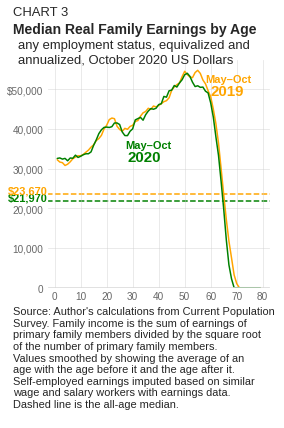

In [10]:
# Chart 3
result = {}
for year in years:
    result[year] = {}
    for age in range(0, 81):
        query = 'AGE == @age and FAMNUM == 1'
        dfa = d[year].query(query)
        result[year][age] = binned_wage(dfa, wage_var='FAMRWKWAGE', weight='PWSSWGT') * 52
        
(pd.DataFrame(result).rolling(3).mean().shift(-1)
   .dropna().plot(color=['orange', 'green'], figsize=(4, 4.2), zorder=2, legend=None))
plt.axhline(y=medfam[2019], color='orange', linestyle='dashed', zorder=0)
plt.axhline(y=medfam[2020], color='green', linestyle='dashed', zorder=0)
plt.axhline(y=0, color='lightgray')
plt.text(-16, 68600, 'CHART 3', size=13)
plt.text(-16, 64000, 'Median Real Family Earnings by Age', 
          fontsize=14, weight='bold')
plt.text(-14, 60400, 'any employment status, equivalized and ', size=13)
plt.text(-14, 56800, 'annualized, October 2020 US Dollars', size=13)
plt.yticks([50000, 40000, 30000, 20000, 10000, 0], ['$50,000', '40,000','30,000', '20,000', '10,000', '0'], size=10, alpha=0.7)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80], size=10, alpha=0.7)
plt.grid(True, which='major', axis='y', alpha=0.5)
plt.grid(True, which='major', axis='x', alpha=0.5)
plt.ylim(bottom=0)
plt.text(28, 32000, '2020', size=15, color='green', weight='bold')
plt.text(27, 35200, 'May–Oct', size=11, color='green', weight='bold')
plt.text(-18, medfam[2020], f'${round(medfam[2020], -1):,.0f}', size=11, color='green', weight='bold')
plt.text(60, 48600, '2019', size=15, color='orange', weight='bold')
plt.text(58, 51800, 'May–Oct', size=11, color='orange', weight='bold')
plt.text(-18, medfam[2019], f'${round(medfam[2019], -1):,.0f}', size=11, color='orange', weight='bold')
text = """
Source: Author's calculations from Current Population 
Survey. Family income is the sum of earnings of
primary family members divided by the square root
of the number of primary family members. 
Values smoothed by showing the average of an 
age with the age before it and the age after it. 
Self-employed earnings imputed based on similar
wage and salary workers with earnings data.
Dashed line is the all-age median. 
"""
plt.text(-16, -33000, text, size=11)
plt.show();

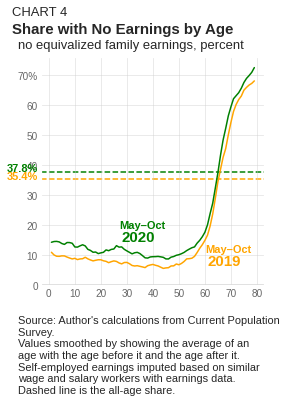

In [11]:
# Chart 4
result = {}
share = {}
for year in years:
    result[year] = {}
    for age in range(0, 81):
        query = 'AGE == @age and FAMNUM == 1'
        dfa = d[year].query(query)
        result[year][age] = (dfa.query('FAMRWKWAGE < 1').PWSSWGT.sum() / 
                             dfa.PWSSWGT.sum()) * 100
        
    share[year] = (d[year].query('FAMRWKWAGE < 1').PWSSWGT.sum() / 
                   d[year].PWSSWGT.sum()) * 100
        
(pd.DataFrame(result).rolling(3).mean().shift(-1)
   .dropna().plot(color=['orange', 'green'], figsize=(4, 4.2), zorder=2, legend=None))
plt.axhline(y=0, color='lightgray')
plt.text(-14, 90, 'CHART 4', size=13)
plt.text(-14, 84, 'Share with No Earnings by Age', 
          fontsize=15, weight='bold')
plt.text(-12, 79, 'no equivalized family earnings, percent', size=13)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], ['0', '10', '20', '30', '40', '50', '60', '70%'], size=10, alpha=0.7)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80], size=10, alpha=0.7)
plt.grid(True, which='major', axis='y', alpha=0.5)
plt.grid(True, which='major', axis='x', alpha=0.5)
plt.ylim(bottom=0)
plt.text(28, 14.5, '2020', size=15, color='green', weight='bold')
plt.text(27, 19, 'May–Oct', size=11, color='green', weight='bold')
plt.text(61, 6.5, '2019', size=15, color='orange', weight='bold')
plt.text(60, 11, 'May–Oct', size=11, color='orange', weight='bold')
text = """
Source: Author's calculations from Current Population 
Survey. 
Values smoothed by showing the average of an 
age with the age before it and the age after it. 
Self-employed earnings imputed based on similar
wage and salary workers with earnings data.
Dashed line is the all-age share. 
"""
plt.text(-12, -40, text, size=11)

plt.axhline(y=share[2019], color='orange', linestyle='dashed', zorder=0)
plt.axhline(y=share[2020], color='green', linestyle='dashed', zorder=0)
plt.text(-16, share[2020], f'{share[2020]:.1f}%', size=11, color='green', weight='bold')
plt.text(-16, share[2019], f'{share[2019]:.1f}%', size=11, color='orange', weight='bold')
plt.show();